# Variability

Investigate the differences in transcriptome variability between drugs that target the same system

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import scipy.stats as stats

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [16]:
import gseapy as gp
from gseapy.plot import gseaplot

In [51]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
data_path = '/data_volume/memento/sciplex/'

In [5]:
ct = 'A549'

In [6]:
adata = sc.read(data_path + 'h5ad/{}.h5ad'.format(ct))

### Define the drug classes

In [7]:
target_list = [
    'Aurora Kinase',
    'DNA/RNA Synthesis',
    'HDAC',
    'Histone Methyltransferase',
    'JAK',
    'PARP',
    'Sirtuin']

target_to_dir = {
    'Aurora Kinase':'aurora',
    'DNA/RNA Synthesis':'dna_rna',
    'HDAC':'hdac',
    'Histone Methyltransferase':'histmeth',
    'JAK':'jak',
    'PARP':'parp',
    'Sirtuin':'sirt'}

### Setup memento

In [12]:
adata.obs['q'] = 0.05

In [13]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.07)

Version 0.0.6


In [63]:
def get_combined_1d_result(target, col='dv_pval'):
    
    drug_counts = adata.obs.query('target == "{}"'.format(target)).product_name.value_counts()
    drug_list = drug_counts[drug_counts > 0].index.tolist()

    result = pd.DataFrame()
    start = True
    for drug1, drug2 in itertools.combinations(drug_list,2):

        subset = sc.read(data_path + '{}/{}_vs_{}_stratified.h5ad'.format(target_to_dir[target], drug1, drug2))
        df = memento.get_1d_ht_result(subset)
        df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
        df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
        if start:

            result['gene'] = df['gene']
            result['{}_{}'.format(drug1, drug2)] = df[col]
            start = False
        else:
            result = result.merge(df[['gene', col]].rename(columns={col:'{}_{}'.format(drug1, drug2)}), how='outer')
            
        result['num_sig'] = (result.iloc[:, 1:] < 0.1).sum()
            
    combined_pvals = []
    for g in result.gene:
        pvalues = result.query('gene == "{}"'.format(g)).iloc[0, 1:].values.astype(float)
        chisq, pv = stats.combine_pvalues(pvalues[np.isfinite(pvalues)])
        combined_pvals.append((g, chisq, pv))

    combined_pvals = pd.DataFrame(combined_pvals, columns=['gene', 'chisq', 'pv'])
    combined_pvals['fdr'] = memento.util._fdrcorrect(combined_pvals['pv'])
    
    return combined_pvals

In [64]:
target = 'HDAC'

In [65]:
combined_dv = get_combined_1d_result(target, col='dv_pval')

In [66]:
combined_de = get_combined_1d_result(target, col='de_pval')

In [69]:
enr = gp.enrichr(gene_list=combined_de.query('fdr < 0.005').sort_values('fdr').gene,
                 gene_sets=['WikiPathways_2019_Human'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )
enr.results.head(10)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2019_Human,Cytoplasmic Ribosomal Proteins WP477,41/89,8.689642e-23,3.536684e-20,0,0,10.637261,540.344392,RPL10;RPL31;RPLP1;RPL12;RPLP0;RPL11;RPL36A;RPL...
1,WikiPathways_2019_Human,Androgen receptor signaling pathway WP138,26/90,1.624941e-09,3.306754e-07,0,0,5.004076,101.271464,RB1;ROCK1;FHL2;PTEN;UBE3A;PARK7;BRCA1;EGFR;CCN...
2,WikiPathways_2019_Human,VEGFA-VEGFR2 Signaling Pathway WP3888,46/236,2.679313e-09,3.634934e-07,0,0,3.001941,59.251430,YWHAE;ITGB1;HDAC4;ROCK1;MAPKAP1;CLTC;FHL2;TXN;...
3,WikiPathways_2019_Human,Integrated Breast Cancer Pathway WP1984,33/151,2.645006e-08,2.691294e-06,0,0,3.450844,60.210352,RB1;ATF1;RALA;BMPR2;IRS1;ZMYND8;ODC1;PTEN;BRCA...
4,WikiPathways_2019_Human,Leptin signaling pathway WP2034,20/76,6.476381e-07,5.271774e-05,0,0,4.383506,62.464673,NCOA1;KHDRBS1;ROCK1;IRS1;RPS6;STAT3;PTEN;MAPK1...
5,WikiPathways_2019_Human,Brain-Derived Neurotrophic Factor (BDNF) signa...,29/144,1.108594e-06,7.202015e-05,0,0,3.103835,42.561081,CYFIP1;IRS1;IRS2;FOXO3;IKBKB;DPYSL2;RACK1;SPP1...
6,WikiPathways_2019_Human,Adipogenesis WP236,27/130,1.375350e-06,7.202015e-05,0,0,3.224237,43.516886,RB1;IRS1;EPAS1;CELF1;SERPINE1;IRS2;NR3C1;HIF1A...
7,WikiPathways_2019_Human,Metabolic reprogramming in colon cancer WP4290,14/42,1.415629e-06,7.202015e-05,0,0,6.121765,82.447542,GPI;G6PD;SLC1A5;PGD;GLS;ACLY;PKM;PGK1;SUCLG2;T...
8,WikiPathways_2019_Human,Sterol Regulatory Element-Binding Proteins (SR...,18/69,2.669275e-06,1.207105e-04,0,0,4.327345,55.535867,SREBF1;MBTPS1;FDPS;SEC23A;SEC24A;HMGCS1;SIRT1;...
9,WikiPathways_2019_Human,Ciliary landscape WP4352,35/216,1.656884e-05,6.612817e-04,0,0,2.381082,26.210915,RB1;DOCK5;PSMD12;CTBP2;MCM8;UBE2D2;IQGAP1;IQGA...


In [71]:
enr = gp.enrichr(gene_list=combined_dv.query('fdr < 0.005').sort_values('fdr').gene,
                 gene_sets=['WikiPathways_2019_Human'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )
enr.results.head(30)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2019_Human,mRNA Processing WP411,21/126,0.000002,0.000540,0,0,3.739346,49.490404,SRPK2;TMED10;CELF1;CPSF3;NONO;HNRNPR;PTBP2;SRP...
1,WikiPathways_2019_Human,Pathways in clear cell renal cell carcinoma WP...,16/85,0.000006,0.000540,0,0,4.322328,51.974195,TPI1;TGFB1;KSR1;PTEN;TSC2;ENO1;ACACB;ACACA;HK1...
2,WikiPathways_2019_Human,Insulin Signaling WP481,23/160,0.000008,0.000540,0,0,3.139766,36.894882,XBP1;ARF1;PRKAA1;PTEN;TSC2;PIK3CB;PIK3C2A;CBL;...
3,WikiPathways_2019_Human,Nuclear Receptors Meta-Pathway WP2882,36/319,0.000009,0.000540,0,0,2.391494,27.848735,AMIGO2;MGST1;KEAP1;SLC2A3;TXN;ARL5B;SEC14L1;SC...
4,WikiPathways_2019_Human,AMP-activated Protein Kinase (AMPK) Signaling ...,14/69,0.000009,0.000540,0,0,4.738905,54.959453,CPT1A;PRKAA1;PRKAG1;TSC2;PIK3CB;EEF2;ACACB;ACA...
5,WikiPathways_2019_Human,Thermogenesis WP4321,18/108,0.000010,0.000540,0,0,3.731225,43.103343,SMARCC1;CPT1A;PRKAA1;PRKAG1;TSC2;MAPK14;ACTB;A...
6,WikiPathways_2019_Human,EGF/EGFR Signaling Pathway WP437,23/162,0.000010,0.000540,0,0,3.094261,35.712699,USP6NL;ERRFI1;USP8;ROCK1;NCOA3;PTEN;BRAF;ASAP1...
7,WikiPathways_2019_Human,Cytoplasmic Ribosomal Proteins WP477,16/89,0.000011,0.000540,0,0,4.084623,46.605830,RPL32;RPS7;RPL34;RPL23;RPS5;RPL10A;RPL6;RPL7;R...
8,WikiPathways_2019_Human,Sterol Regulatory Element-Binding Proteins (SR...,13/69,0.000044,0.001892,0,0,4.317355,43.342615,MBTPS1;FDPS;PRKAA1;SEC24B;HMGCS1;PRKAG1;MED15;...
9,WikiPathways_2019_Human,Epithelial to mesenchymal transition in colore...,21/159,0.000069,0.002484,0,0,2.840178,27.203673,SMAD2;DSP;SUZ12;NOTCH3;TGFB1;JUP;GDF15;WNT7B;P...


### GSEA + Enrichr

In [40]:
import gseapy as gp
from gseapy.plot import gseaplot


In [41]:
combined_pvals.query('fdr < 0.01').shape

(1050, 4)

In [46]:
enr = gp.enrichr(gene_list=combined_pvals.query('fdr < 0.005').sort_values('fdr').gene,
                 gene_sets=['GO_Biological_Process_2021'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )
enr.results.head(10)


In [47]:
enr.results.head(10)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,nuclear-transcribed mRNA catabolic process (GO...,28/171,5.288169e-08,0.000200,0,0,3.679047,61.643208,SMG1;RPL32;RPL34;PARN;CASC3;RPL10A;RPL6;RPL7;S...
1,GO_Biological_Process_2021,"nuclear-transcribed mRNA catabolic process, no...",21/113,2.762529e-07,0.000521,0,0,4.270673,64.495482,UPF2;SMG1;RPL32;RPS7;RPL34;RPL23;RPS5;CASC3;RP...
2,GO_Biological_Process_2021,gene expression (GO:0010467),42/356,4.945169e-07,0.000622,0,0,2.525697,36.672322,POM121;SMG1;RPL32;RPL34;CASC3;RPL10A;BICD1;RPL...
3,GO_Biological_Process_2021,cellular protein modification process (GO:0006...,87/1025,2.836706e-06,0.002677,0,0,1.773571,22.653589,PRKCSH;UBE2D2;NGLY1;PRKAG1;PTEN;KEAP1;CHM;MIA3...
4,GO_Biological_Process_2021,cytoplasmic translation (GO:0002181),17/93,4.693658e-06,0.003544,0,0,4.172053,51.188160,EIF4A1;RPL32;RPS7;RPL34;RPL23;RPS5;RPL10A;RPL6...
5,GO_Biological_Process_2021,negative regulation of protein modification pr...,15/81,1.430557e-05,0.009001,0,0,4.232871,47.217086,G6PD;PRKAA1;CRTAP;TGFB1;YWHAB;NTRK3;PTEN;CDYL;...
6,GO_Biological_Process_2021,cotranslational protein targeting to membrane ...,16/94,2.263429e-05,0.012206,0,0,3.821777,40.877899,RPL32;RPS7;RPL34;RPL23;RPS5;SSR2;RPL10A;RPL6;R...
7,GO_Biological_Process_2021,organelle assembly (GO:0070925),42/425,4.193574e-05,0.017905,0,0,2.063017,20.793919,DDX6;ASAP1;AMBRA1;FNBP1L;LIMD1;BICD1;CDC14B;PC...
8,GO_Biological_Process_2021,phosphorylation (GO:0016310),40/400,4.874394e-05,0.017905,0,0,2.088664,20.738202,PRKAA1;PANK2;CAMK2D;ROCK1;PRKAG1;PIK3CB;LIMD1;...
9,GO_Biological_Process_2021,protein stabilization (GO:0050821),23/179,4.938509e-05,0.017905,0,0,2.754577,27.314005,CCT2;CRTAP;HSP90AA1;COG7;HIP1;RPS7;RPL23;PTGES...


In [48]:
enr = gp.enrichr(gene_list=combined_pvals.query('fdr < 0.01').sort_values('fdr').gene,
                 gene_sets=['WikiPathways_2019_Human'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [49]:
df = enr.results.sort_values('Odds Ratio', ascending=False)
df[df['Adjusted P-value'] < 0.1].head(30)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
39,WikiPathways_2019_Human,Somatroph axis (GH) and its relationship to di...,3/6,0.002560,0.024962,0,0,18.096466,107.993773,PTEN;SIRT1;IGF1R
29,WikiPathways_2019_Human,Leptin and adiponectin WP3934,4/10,0.001229,0.015979,0,0,12.073932,80.912494,CPT1A;PRKAA1;PRKAG1;ACACA
46,WikiPathways_2019_Human,HIF1A and PPARG regulation of glycolysis WP2456,3/8,0.006622,0.054281,0,0,10.856734,54.472477,TPI1;PPARG;GAPDH
55,WikiPathways_2019_Human,Cytosine methylation WP3585,3/9,0.009548,0.064566,0,0,9.046800,42.080520,IDH1;TDG;TET3
27,WikiPathways_2019_Human,SREBF and miR33 in cholesterol and lipid homeo...,5/16,0.001061,0.014782,0,0,8.237930,56.415759,PRKAA1;HMGCS1;SIRT1;MED15;LDLR
26,WikiPathways_2019_Human,Cori Cycle WP1946,5/16,0.001061,0.014782,0,0,8.237930,56.415759,G6PD;TPI1;GAPDH;PFKP;HK1
17,WikiPathways_2019_Human,Hereditary leiomyomatosis and renal cell carci...,6/20,0.000423,0.009175,0,0,7.773399,60.376130,PRKAA1;PRKAG1;KEAP1;ACACB;ACACA;NFE2L2
35,WikiPathways_2019_Human,TGF-B Signaling in Thyroid Cells for Epithelia...,5/18,0.001907,0.020659,0,0,6.969820,43.646645,SMAD2;TGFB1;CDH1;ID1;MAPK1
34,WikiPathways_2019_Human,Inhibition of exosome biogenesis and secretion...,5/18,0.001907,0.020659,0,0,6.969820,43.646645,PDCD6IP;RRAS2;MAPK1;BRAF;RAB5A
72,WikiPathways_2019_Human,"NAD metabolism, sirtuins and aging WP3630",3/11,0.017336,0.091587,0,0,6.784384,27.510354,NAMPT;PPARG;SIRT1


### Run 1D test against log10(dosage) 

Use different drugs as strata

In [86]:
for target in target_list:
    
    print('Starting ', target, '...')
    
#     target = 'HDAC'
    
    subset = adata[((adata.obs.target==target)) | (adata.obs.vehicle)].copy().copy()
    subset.obs['dose_indicator'] = subset.obs.dose.apply(lambda x: {0:0.0 ,10:1.0, 100:2.0, 1000:3.0, 10000:1.0}[x])
    subset.obs['dose_level'] = 'dose_' + subset.obs['dose'].astype(str)

    memento.create_groups(subset, label_columns=['dose_indicator'])
    memento.compute_1d_moments(subset, min_perc_group=.9)
    memento.ht_1d_moments(
        subset, 
        formula_like='1 + dose_indicator',
        treatment_col='dose_indicator', 
        num_boot=20000, 
        verbose=0,
        num_cpus=92,
        resampling='permutation',
        approx=False)
    
    subset.write(data_path + 'dosage/{}.h5ad'.format(target_to_dir[target]))
    
#     break

Starting  Aurora Kinase ...


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Starting  DNA/RNA Synthesis ...


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Starting  HDAC ...


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Starting  Histone Methyltransferase ...


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Starting  JAK ...


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Starting  PARP ...


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Starting  Sirtuin ...


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


### AK

In [87]:
for target in target_list:
    
#     target = 'DNA/RNA Synthesis'
#     target = 'PARP'
    subset = sc.read(data_path + 'dosage/{}.h5ad'.format(target_to_dir[target]))

    df = memento.get_1d_ht_result(subset)
    df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
    
    df = df.query('de_fdr < 0.05')
    df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])

    
    print(target)
    
    if df.query('dv_fdr <0.1').shape[0] > 10:
        enr = gp.enrichr(gene_list=df.query('dv_fdr <0.1 & dv_coef < 0').sort_values('dv_coef', ascending=False).gene,
             gene_sets=['WikiPathways_2019_Human'],
             organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
             outdir=None,
             cutoff=0.5 # test dataset, use lower value from range(0,1)
                    )
        print(enr.results.sort_values('Adjusted P-value').head(10)[['Term', 'Adjusted P-value']])
        


Aurora Kinase
                                                 Term  Adjusted P-value
0                                 NRF2 pathway WP2884          0.216304
1   Corticotropin-releasing hormone signaling path...          0.216304
2   Transcription co-factors SKI and SKIL protein ...          0.285740
3   miRNA targets in ECM and membrane receptors WP...          0.318287
27                      Leptin and adiponectin WP3934          0.329234
26  Interleukin-1 Induced Activation of NF-kappa-B...          0.329234
25                        Vitamin D Metabolism WP1531          0.329234
24                        Genotoxicity pathway WP4286          0.329234
23          MECP2 and Associated Rett Syndrome WP3584          0.329234
22                    Ectoderm Differentiation WP2858          0.329234


In [85]:
df.sort_values('dv_pval')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
708,ALDH3A1,0.024723,0.006348,0.000945,-0.051203,0.017503,0.003700,0.040956,0.351482
374,RAB10,0.028597,0.005760,0.000453,-0.048681,0.020574,0.018049,0.040956,0.491125
2420,TXNRD1,-0.024701,0.005032,0.000467,0.041081,0.017598,0.020149,0.040956,0.491125
1935,FAM102A,0.064392,0.015508,0.000218,0.104329,0.045584,0.023249,0.037819,0.491125
2451,MT-ND1,0.022817,0.005120,0.000141,-0.035680,0.016176,0.025849,0.034335,0.491125
1334,MYOF,-0.027497,0.008386,0.001200,0.041371,0.020680,0.046148,0.042377,0.522474
2370,SRGAP1,-0.026982,0.008497,0.001350,0.082630,0.041846,0.051147,0.042742,0.522474
1265,FLNB,-0.047415,0.007736,0.000014,0.054812,0.028546,0.054697,0.012811,0.522474
1533,SPATA5,-0.045156,0.013227,0.000950,-0.146750,0.080089,0.065847,0.040956,0.522474
49,NCAPD2,-0.061872,0.011100,0.000266,0.093272,0.051068,0.067697,0.037819,0.522474


In [81]:
# df = memento.get_1d_ht_result(subset)

(array([115.,  96.,  70.,  75.,  62.,  57.,  68.,  58.,  58.,  73.,  66.,
         65.,  65.,  51.,  69.,  69.,  50.,  51.,  62.,  53.,  61.,  62.,
         59.,  64.,  70.,  60.,  63.,  58.,  63.,  59.,  58.,  65.,  57.,
         66.,  74.,  67.,  73.,  67.,  68.,  64.]),
 array([3.74988086e-04, 2.53606136e-02, 5.03462392e-02, 7.53318647e-02,
        1.00317490e-01, 1.25303116e-01, 1.50288741e-01, 1.75274367e-01,
        2.00259992e-01, 2.25245618e-01, 2.50231244e-01, 2.75216869e-01,
        3.00202495e-01, 3.25188120e-01, 3.50173746e-01, 3.75159371e-01,
        4.00144997e-01, 4.25130622e-01, 4.50116248e-01, 4.75101873e-01,
        5.00087499e-01, 5.25073125e-01, 5.50058750e-01, 5.75044376e-01,
        6.00030001e-01, 6.25015627e-01, 6.50001252e-01, 6.74986878e-01,
        6.99972503e-01, 7.24958129e-01, 7.49943755e-01, 7.74929380e-01,
        7.99915006e-01, 8.24900631e-01, 8.49886257e-01, 8.74871882e-01,
        8.99857508e-01, 9.24843133e-01, 9.49828759e-01, 9.74814384e-01,
      

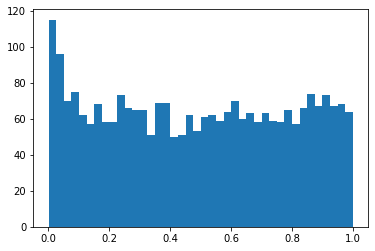

In [82]:
plt.hist(df.dv_pval, bins=40)